In [1]:
import numpy as np
import nltk
import pandas as pd
import collections
from absl import logging
import tensorflow as tf
import tensorflow_hub as hub
import matplotlib.pyplot as plt
import os
import re
import seaborn as sns

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [2]:
from google.colab import drive
drive.mount("/content/drive/")
df = pd.read_csv("/content/drive/My Drive/NLP summer Internship/Cleanned_Complaints.csv")
df=df[df["Label"]!="Other financial service"]
df=df.dropna()

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [3]:
# Load pretrained model - google universal sentence encoder
module_url = "https://tfhub.dev/google/universal-sentence-encoder/4" 
model = hub.load(module_url)
def embed(input):
  return model(input)

In [5]:
# Prepare four vendor datasets and one Well's Fargo set
df_wells=df[df["Company"]=="WELLS FARGO & COMPANY"]
credit_unions=["TRANSUNION INTERMEDIATE HOLDINGS, INC."]
banks=["CITIBANK, N.A.","BANK OF AMERICA, NATIONAL ASSOCIATION","JPMORGAN CHASE & CO.","U.S. BANCORP"]
mortgages=["Ocwen Financial Corporation","NATIONSTAR MORTGAGE","Ditech Financial LLC","SELECT PORTFOLIO SERVICING, INC.",
           "Specialized Loan Servicing Holdings LLC","SYNCHRONY FINANCIAL"]
balanced=["Santander Consumer USA Holdings Inc.","Ocwen Financial Corporation","BANK OF AMERICA, NATIONAL ASSOCIATION",
          "JPMORGAN CHASE & CO.","U.S. BANCORP","PNC Bank N.A.","UNITED SERVICES AUTOMOBILE ASSOCIATION","SUNTRUST BANKS, INC."]
df_cu=df[df["Company"].isin(credit_unions)]
df_banks=df[df["Company"].isin(banks)]
df_mortgages=df[df["Company"].isin(mortgages)]
df_balanced=df[df["Company"].isin(balanced)]

In [6]:
# Check number of documents in each dataset
cu_complaint=df_cu["Complaint_reduced"]
banks_complaint=df_banks["Complaint_reduced"]
mortgages_complaint=df_mortgages["Complaint_reduced"]
balanced_complaint=df_balanced["Complaint_reduced"]
wells_complaint=df_wells["Complaint_reduced"]
print(cu_complaint.shape,banks_complaint.shape,mortgages_complaint.shape,balanced_complaint.shape,wells_complaint.shape)

(55056,) (58302,) (29905,) (57125,) (17613,)


In [7]:
# Coding block to calculate pairwise similarity matrix
# This will take 10 minutes to embed and require around 15G memory
print("now embedding wells dataset")
# Embedding wells dataset
wells_embed=np.array(embed(wells_complaint))

print("now embedding cu dataset")
# Embedding cu dataset
cu_embed1=embed(cu_complaint[0:15000])
cu_embed2=embed(cu_complaint[15000:30000])
cu_embed3=embed(cu_complaint[30000:45000])
cu_embed4=embed(cu_complaint[45000:])
cu_embed=np.concatenate((cu_embed1,cu_embed2,cu_embed3,cu_embed4),axis=0)

print("now embedding mortgages dataset")
# Embedding mortgages dataset
mortgages_embed1=embed(mortgages_complaint[0:15000])
mortgages_embed2=embed(mortgages_complaint[15000:])
mortgages_embed=np.concatenate((mortgages_embed1,mortgages_embed2),axis=0)

print("now embedding banks dataset")
# Embedding banks dataset
banks_embed1=embed(banks_complaint[0:15000])
banks_embed2=embed(banks_complaint[15000:30000])
banks_embed3=embed(banks_complaint[30000:45000])
banks_embed4=embed(banks_complaint[45000:])
banks_embed=np.concatenate((banks_embed1,banks_embed2,banks_embed3,banks_embed4),axis=0)

print("now embedding balanced dataset")
# Embedding banks dataset
balanced_embed1=embed(balanced_complaint[0:15000])
balanced_embed2=embed(balanced_complaint[15000:30000])
balanced_embed3=embed(balanced_complaint[30000:45000])
balanced_embed4=embed(balanced_complaint[45000:])
balanced_embed=np.concatenate((balanced_embed1,balanced_embed2,balanced_embed3,balanced_embed4),axis=0)

now embedding wells dataset
now embedding cu dataset
now embedding mortgages dataset
now embedding banks dataset
now embedding balanced dataset


#### Combined all the embeddings and clustering 

In [12]:
#Concatenate all datasets(all vendors+ test sets together, depend on which embedding is used)
#SVD dimension reduction
from sklearn.decomposition import TruncatedSVD
together=np.concatenate((cu_embed,mortgages_embed,banks_embed,balanced_embed,wells_embed),axis=0)
svd = TruncatedSVD(n_components=110, n_iter=10, random_state=0)
svd.fit(together)
#check variance_ratio recommend above 80%
print(svd.explained_variance_ratio_.sum())

0.8160601


In [13]:
#check matrix dimension after svd
together_reduced=svd.transform(together)
together_reduced.shape

(218001, 110)

In [14]:
#Check elbow graph to pick clusters (heuristic)
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn import metrics 
from scipy.spatial.distance import cdist
import progressbar
from time import sleep

#maximum cluster number to be checked by elbow method, this can be changed, minimum is 2
number_of_cluster_range=20 
#progress bar
bar = progressbar.ProgressBar(maxval=number_of_cluster_range, \
    widgets=[progressbar.Bar('=', '[', ']'), ' ', progressbar.Percentage()])
bar.start()
#Compile elbow graph
axis=[]
elbow=[]
for i in range(2,number_of_cluster_range+1):
  KmeansModel = KMeans(n_clusters=i, random_state=0)
  Preds=KmeansModel.fit_predict(together_reduced)
  axis.append(i)
  elbow.append(KmeansModel.inertia_)
  bar.update(i)
bar.finish()

[========================================================================] 100%


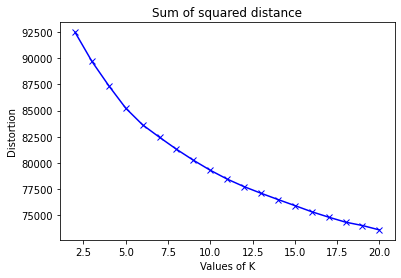

In [ ]:
#Plot Elbow graph
plt.plot(axis, elbow, 'bx-') 
plt.title('Values of K') 
plt.xlabel('Values of K') 
plt.ylabel('Distortion') 
plt.title('Sum of squared distance') 
plt.show() 

#### Setting number of clusters

In [35]:
num_clusters=10

In [36]:
# Choose n_clusters using elbow method, if the dataset is small, silhouette graph could be used
KmeansModel = KMeans(n_clusters=num_clusters, random_state=0)
Preds=KmeansModel.fit_predict(together_reduced)

In [37]:
# Assign cluster numbers to each of the document in all datasets
n_cu=cu_embed.shape[0]
n_mortgages=mortgages_embed.shape[0]
n_banks=banks_embed.shape[0]
n_balanced=balanced_embed.shape[0]
cu_wells_vendor_label=Preds[0:n_cu]
mortgages_wells_vendor_label=Preds[n_cu:n_mortgages+n_cu]
banks_wells_vendor_label=Preds[n_mortgages+n_cu:n_mortgages+n_cu+n_banks]
balanced_wells_vendor_label=Preds[n_mortgages+n_cu+n_banks:n_mortgages+n_cu+n_banks+n_balanced]
wells_label=Preds[n_mortgages+n_cu+n_banks+n_balanced:]

In [38]:
# Extract the frequency and label for each clusters for the vendors and Wells Fargo dataset
label_vendor_cu,count_vendor_cu=np.unique(cu_wells_vendor_label,return_counts=True)
label_vendor_mortgages,count_vendor_mortgages=np.unique(mortgages_wells_vendor_label,return_counts=True)
label_vendor_banks,count_vendor_banks=np.unique(banks_wells_vendor_label,return_counts=True)
label_vendor_balanced,count_vendor_balanced=np.unique(balanced_wells_vendor_label,return_counts=True)
label_wells,count_wells=np.unique(wells_label,return_counts=True)

In [39]:
# check if each vendor dataset has value in each cluster, should equal to num_cluster which is defined earlier
print(len(label_vendor_cu),len(label_vendor_mortgages),len(label_vendor_banks),len(label_vendor_balanced),len(label_wells))

10 10 10 10 10


In [40]:
# Helper function normalize cluster frequency
# Normalize frequency to 100 and assign 0 to count if no document fall in one of the cluster

# k: number of clusters, int
# c_count:cluster counts, numpy array
# c_label:cluster labels, numpy arrary
# return: normalized count in each cluster, numpy array, shape=(k,)

def normalize(c_count,c_label, k):
  result=np.zeros(k)
  for i in range(len(c_label)):
    result[c_label[i]]=c_count[i]
  result=result/np.sum(result)
  return result

In [41]:
# Apply normalize function to all dataset
percent_cu=normalize(count_vendor_cu,label_vendor_cu,num_clusters)
percent_mortgages=normalize(count_vendor_mortgages,label_vendor_mortgages,num_clusters)
percent_banks=normalize(count_vendor_banks,label_vendor_banks,num_clusters)
percent_balanced=normalize(count_vendor_balanced,label_vendor_balanced,num_clusters)
percent_wells=normalize(count_wells,label_wells,num_clusters)

In [42]:
# Print normalized result
print(percent_cu)
print(percent_mortgages)
print(percent_banks)
print(percent_balanced)
print(percent_wells)

[0.0250109  0.01685557 0.04084932 0.05913978 0.11442895 0.00410491
 0.2900138  0.02973336 0.39508864 0.02477477]
[0.16666109 0.06791506 0.19518475 0.21952851 0.03557933 0.02163518
 0.04945661 0.13827119 0.04704899 0.05871928]
[0.06052966 0.23230764 0.08606909 0.09416487 0.02780351 0.23488045
 0.04315461 0.12828033 0.03384103 0.05896882]
[0.10252954 0.13515974 0.0940744  0.11284026 0.02828884 0.25698031
 0.03879212 0.13235886 0.03350547 0.06547046]
[0.15698632 0.06188611 0.10077783 0.16487821 0.02941009 0.17753932
 0.03792653 0.17799353 0.02827457 0.06432749]


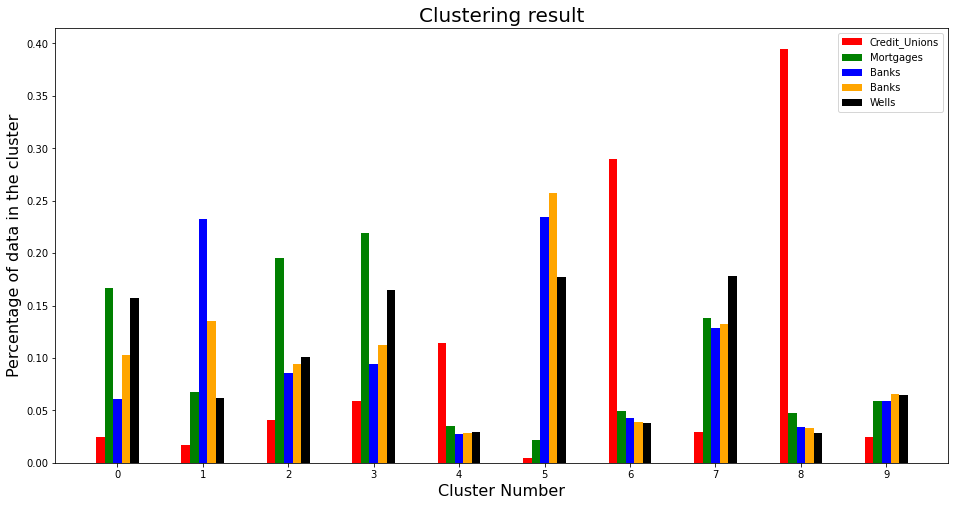

In [54]:
# Graph the cluster result
labels = list(range(0,num_clusters))

x = np.arange(len(labels))  # the label locations
width = 0.1  # the width of the bars

fig, ax = plt.subplots(figsize=(16,8))
rects1 = ax.bar(x -2*width, percent_cu, width, label='Credit_Unions',color="red")
rects2 = ax.bar(x -width, percent_mortgages, width, label='Mortgages',color="green")
rects3 = ax.bar(x, percent_banks, width, label='Banks',color="blue")
rects4 = ax.bar(x +width, percent_balanced, width, label='Banks',color="orange")
rects5 = ax.bar(x +2*width, percent_wells, width, label='Wells',color="black")

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Percentage of data in the cluster',size=16)
ax.set_xlabel('Cluster Number',size=16)
ax.set_title('Clustering result',size=20)
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend()

In [48]:
score_final_cu=np.sum(np.abs(np.array(percent_cu)-np.array(percent_wells)))/num_clusters*100
score_final_mortgages=np.sum(np.abs(np.array(percent_mortgages)-np.array(percent_wells)))/num_clusters*100
score_final_banks=np.sum(np.abs(np.array(percent_banks)-np.array(percent_wells)))/num_clusters*100
score_final_balanced=np.sum(np.abs(np.array(percent_balanced)-np.array(percent_wells)))/num_clusters*100

In [49]:
print(score_final_cu,score_final_mortgages,score_final_banks,score_final_balanced)

14.078403798989125 4.024693651055515 4.771144142299815 3.199081700767821
